# **Modules**

In [2]:
from data_preparation.generate_sets import main as generate_sets
from data_preparation.datasets import main as generate_loaders_and_test_nan
from data_preparation.induce_nans import main as generate_test_masked
from data_preparation.preprocessing import preprocess_data

from models.MLP_AE import FullyConnectedAutoencoder
from models.Conv_AE import ConvAutoencoder
from models.LSTM_AE import LSTM_Autoencoder
from models.Transformer_Encoder import make_model

from training.train import train_model

from evaluations.nn_loss import ORT_MIT_Loss
from evaluations.utils import load_model, count_parameters
from evaluations.predict import predict
from evaluations.eval_classical_methods import evaluate_set
from evaluations.mse import evaluate_imputation_mse
from evaluations.t_test import t_test


from sklearn.preprocessing import MinMaxScaler

from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_parallel_coordinate

import torch
import pandas as pd
import configue
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(12, 3))

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-42kmy51x because the default path (/home/upbeat_liskov/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# configue
config = configue.load("./config.yaml")
torch.manual_seed(config["random_state"])

# **Data preprocessing**

In [4]:
generate_sets(config) 

Train, validation and test sets created


In [5]:
train, val, test = preprocess_data(config["path_train"], config["path_val"], config["path_test"], MinMaxScaler(), config["columns_to_drop"])
test_nan, test_mask = generate_test_masked(config,test)

masking done


# **DL models**

In [6]:
# Hyperparameters Intervals
## Learning rate
LR = [0.0001, 0.001, 0.01, 0.1]
## Epochs 
EPOCHS=[30,40,50]
## Sequence Length
SEQ_LEN= [12,24,36,48,60,72]
## Batch
BATCH_VALUES=[16,32]
## Loss Function Hyperparameter
LOSS_PARAMS_LIST=[0.5,2,4,8,16]
## AE Architecture hyperparameter
RP = [0.5,0.6,0.7,0.8,0.9]
NUM_TRIALS=100

# Hyperparameters used in Transformer model
## Dropout 
DROPOUT=[0.5,0.6,0.7]
## d_ff
d_ff_vals = [32,64]
## N encoder
N_vals = [1,2,3,4]
## h heads
h_vals =[2,4]
## d_model
d_model_vals = [16,64,128] # d_model%h ==0

## **Transformer Encoder Finetuning**

In [7]:
config_ts_main = configue.load("./training/config_TS.yaml")

def objective_ts(trial: optuna.Trial): 

    config_ts = {
        "learning_rate": trial.suggest_categorical('learning_rate', LR),
        "reduction_parameter": trial.suggest_categorical('reduction_param', RP),
        "epochs": int(trial.suggest_categorical('epochs', EPOCHS)),
        "sequence_length": int(trial.suggest_categorical('sequence_length', SEQ_LEN)),
        "batch_size": int(trial.suggest_categorical('batch_size', BATCH_VALUES)),
        "loss_parameter": trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST),
        "h": trial.suggest_categorical('h', h_vals),
        "N": trial.suggest_categorical('N', N_vals),
        "d_ff": trial.suggest_categorical('d_ff', d_ff_vals),
        "d_model": trial.suggest_categorical('d_model', d_model_vals),
        "dropout": trial.suggest_categorical('dropout', DROPOUT),
        "models_path": config_ts_main["models_path"]
    }

    d_input = train.shape[1]
    print('sequence_length',config_ts["sequence_length"],'batch_size',config_ts["batch_size"],'epochs',config_ts["epochs"])
    TS_model = make_model(d_input=d_input, N=config_ts["N"], d_model=config_ts["d_model"], d_ff=config_ts["d_ff"], h=config_ts["h"], dropout=config_ts["dropout"])
    if torch.cuda.is_available():
        TS_model = TS_model.cuda()  
        
    train_loader_ts, val_loader_ts, test_loader_ts = generate_loaders_and_test_nan(config, config_ts,train, val, test, test_nan, test_mask)

    loss_fn = ORT_MIT_Loss(config_ts["loss_parameter"])
    
    train_loss_list, val_loss_list,TS_model_Path = train_model(TS_model,loss_fn,config_ts,d_input,train_loader_ts,val_loader_ts, is_flatten=False, is_TS=True, is_warmed= False)
         
    return val_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective_ts, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-04-06 14:41:19,006] Trial 99 finished with value: 0.07652857437541213 and parameters: {'learning_rate': 0.001, 'reduction_param': 0.7, 'epochs': 30, 'sequence_length': 24, 'batch_size': 16, 'loss_parameter': 4, 'h': 4, 'N': 1, 'd_ff': 64, 'd_model': 128, 'dropout': 0.5}. Best is trial 80 with value: 0.011904344599890081.


Number of finished trials: 100
Best trial:
  Value: 0.01190
  Params: 
    learning_rate: 0.001
    reduction_param: 0.7
    epochs: 30
    sequence_length: 72
    batch_size: 16
    loss_parameter: 0.5
    h: 4
    N: 1
    d_ff: 64
    d_model: 64
    dropout: 0.5


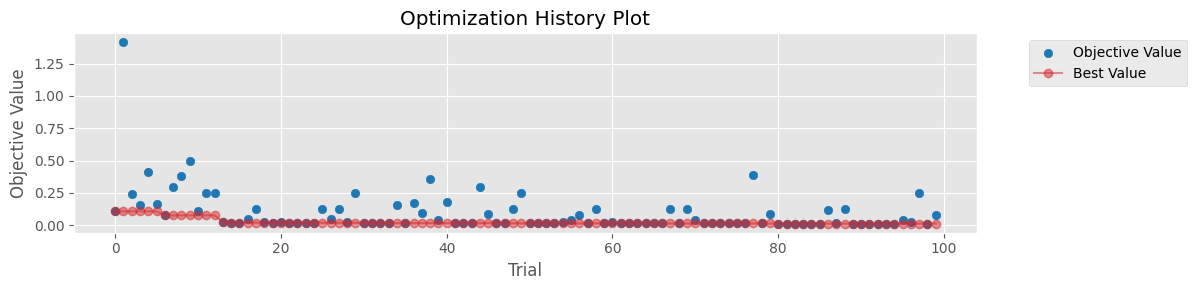

In [8]:
plot_optimization_history(study)
plt.tight_layout()

<AxesSubplot: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

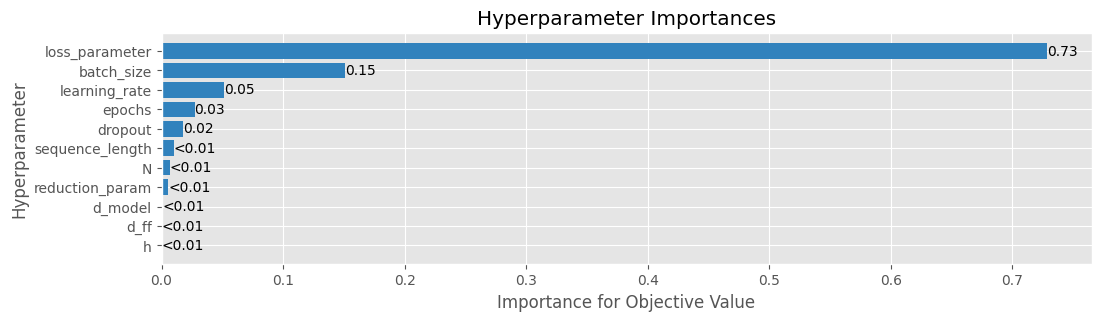

In [9]:
optuna.visualization.matplotlib.plot_param_importances(study)

<AxesSubplot: title={'center': 'Parallel Coordinate Plot'}>

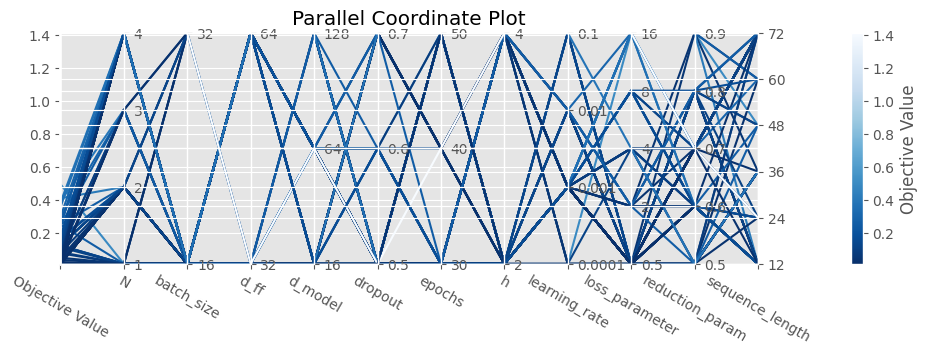

In [11]:
plot_parallel_coordinate(study)